# Inference of Gene Correlations using Pearson


In [1]:
from datetime import date

print("Last run date:", date.today())

Last run date: 2023-03-06


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

import sys
sys.path.append('../')

import lib.NetAnalysis as na
import lib.fun_plotting as fun_plotting
import lib.funcs_general as funcs_general
import lib.funcs_IsingPars as funcs_Ising

%load_ext autoreload
%autoreload 2

matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

# Initial information

In [3]:
path      = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/" 
path_data = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/DATA/"

In [4]:
# genes of OUR dataset
genes_order = np.loadtxt(path_data+"general_info/genes_order.csv", dtype="str") #selected genes

# time steps
time=["00h", "06h", "12h", "24h", "48h"]

# Genes Classification
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative = ["Nr0b1", "Zic3", "Rbpj", "Utf1", "Etv4", "Tcf15"]
committed = ["Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]



# Raw data

In [32]:
df_raw = pd.read_csv(path_data + "GE_data/imp_genes_raw.csv", header=0, index_col=0, sep=",")
# time_sep = np.loadtxt(path+"GE_data/time_sep.txt", dtype=np.int32)
df_raw.index.name = None

df_raw = df_raw.reindex(genes_order)
    
df_raw.head(3)

,AAACCCAGTGACCGTC,AAACGAAAGCGCGTTC,AAACGAACAAGCACCC,AAACGAATCAAGTCGT,AAACGCTTCCGTGACG,AAAGAACGTCAGATTC,AAAGAACTCACTTGTT,AAAGGATCAAATCAAG,AAAGGATTCTGAACGT,AAAGGGCAGCAGGCAT,...,TTTGACTGTCAGCTTA,TTTGACTGTGTTATCG,TTTGACTTCGCCACTT,TTTGATCGTTCTCCAC,TTTGGTTAGAGAGCGG,TTTGGTTGTGATCATC,TTTGGTTTCACGGGCT,TTTGGTTTCCAACACA,TTTGTTGCATCGAAGG,TTTGTTGCATCTCATT
Klf4,1,1,0,1,3,3,0,2,2,0,...,0,2,1,0,0,0,0,0,0,0
Klf2,1,0,1,2,0,2,6,6,1,2,...,0,3,1,0,0,0,3,0,0,2
Esrrb,0,1,0,2,1,0,0,2,0,0,...,0,1,0,0,0,0,1,1,0,0


# Norm Data

In [5]:
# load the Gene Expression data Log Normalized: the columns are the cells and the rows are the genes
df_lN = pd.read_csv(path_data + "GE_data/imp_genes_logNorm.csv", header=0, index_col=0, sep=",").reindex(genes_order)
df_lN.index.name=None

df_lN.head(3)

# load the Gene Expression data Psi Normalized: the columns are the cells and the rows are the genes
df_pN = pd.read_csv(path_data + "GE_data/imp_genes_PsiNorm.csv", header=0, index_col=0, sep=",").reindex(genes_order)
df_pN.index.name = None

df_pN.head(3)


,AAACCCAGTGACCGTC,AAACGAAAGCGCGTTC,AAACGAACAAGCACCC,AAACGAATCAAGTCGT,AAACGCTTCCGTGACG,AAAGAACGTCAGATTC,AAAGAACTCACTTGTT,AAAGGATCAAATCAAG,AAAGGATTCTGAACGT,AAAGGGCAGCAGGCAT,...,TTTGACTGTCAGCTTA,TTTGACTGTGTTATCG,TTTGACTTCGCCACTT,TTTGATCGTTCTCCAC,TTTGGTTAGAGAGCGG,TTTGGTTGTGATCATC,TTTGGTTTCACGGGCT,TTTGGTTTCCAACACA,TTTGTTGCATCGAAGG,TTTGTTGCATCTCATT
Klf4,1.485415,1.338896,0.000000,0.855192,2.511880,1.881212,0.000000,1.267982,1.684245,0.000000,...,0.0,1.592437,1.025867,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
Klf2,1.485415,0.000000,1.338774,1.388465,0.000000,1.479866,2.463433,2.385357,1.075095,1.705082,...,0.0,2.008406,1.025867,0.0,0.0,0.0,2.182156,0.000000,0.0,1.578242
Esrrb,0.000000,1.338896,0.000000,1.388465,1.360576,0.000000,0.000000,1.267982,0.000000,0.000000,...,0.0,1.005610,0.000000,0.0,0.0,0.0,1.123956,0.952262,0.0,0.000000


## Pseudotime

In [6]:
# load the Gene Expression data log normalized: the columns are the cells and the rows are the genes
df_lN_pst= pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST.csv", header=0, index_col=0, sep=",")


# load the Gene Expression data Psi Normalized: the columns are the cells and the rows are the genes
df_pN_pst= pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST.csv", header=0, index_col=0, sep=",")

df_pN_pst.head(3)

,TTCAGGAAGCAGTACG,GTAGATCAGTAGGTTA,CGAAGGACACGGGCTT,GTCGCGAGTCGTCTCT,CCTTCAGGTCCAGCGT,CTCCGATAGCATCCTA,CAACGATAGATGAACT,GTGTCCTAGAATTGCA,TGCGACGTCGTGTCAA,CTCAATTAGGCTAAAT,...,AACAAAGAGAGCGACT,TCATACTAGGTGTGAC,GCCATTCAGCCAGAGT,AACAGGGGTGCACGCT,GATCATGTCTGTAACG,GATTCGAAGATACAGT,GCCAGGTAGAAGAACG,CGTGCTTTCGACGTCG,AGGGTGACAATACGAA,CCACAAAAGCGTGAAC
Klf4,0.000000,0.0,0.000000,0.0,2.534856,2.337277,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,1.502543,0.0,0.000000,0.0,0.0,0.0,0.0
Klf2,1.705748,0.0,3.095388,0.0,1.377622,1.233372,0.0,0.0,2.131445,0.000000,...,1.308057,0.0,0.0,1.502543,0.0,1.389484,0.0,0.0,0.0,0.0
Esrrb,0.000000,0.0,0.000000,0.0,0.000000,1.233372,0.0,0.0,2.131445,1.116785,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


## PST + MB

In [7]:
# Window size for Mini-Bulk
mb_wind = 150

# Threshold for half max
thr = 0.5 

In [8]:
# Mini-Bulk
# load the Gene Expression data log normalized + Pseudo-Time: the columns are the cells and the rows are the genes
df_lN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB.csv", header=0, index_col=0, sep=",")

# load the Gene Expression data Psi Normalized + Pseudo-Time: the columns are the cells and the rows are the genes
df_pN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB.csv", header=0, index_col=0, sep=",")


print("LogNorm dims: ", df_lN_mb_pst.shape, "\nPsiNorm dims: ", df_pN_mb_pst.shape)

LogNorm dims:  (24, 9547) 
PsiNorm dims:  (24, 8124)


# Binarization (Half-max)

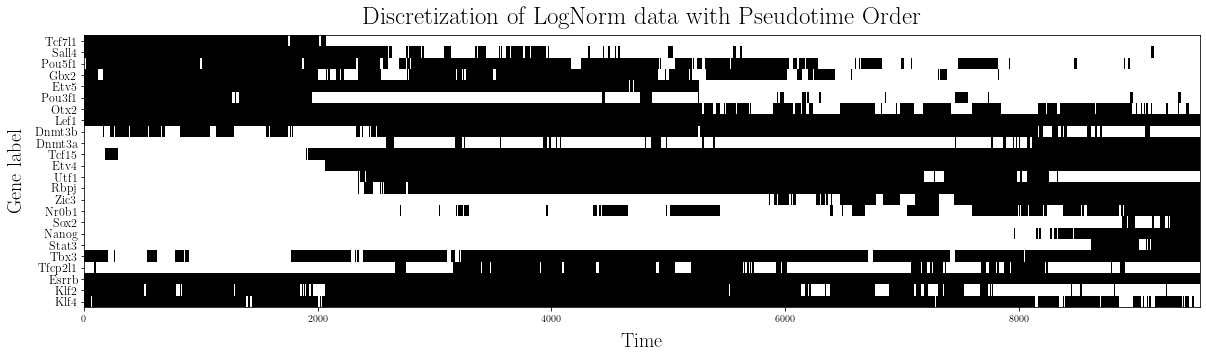

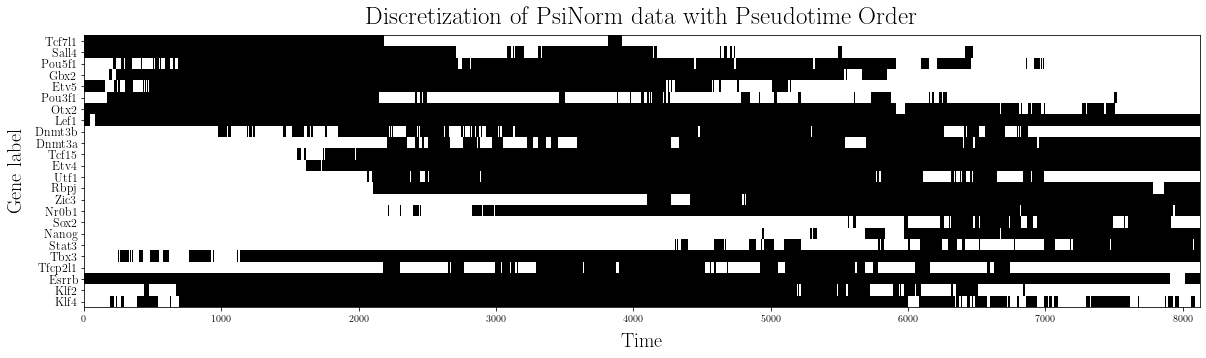

In [9]:
spins_df_lN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins.csv", header=0, index_col=0, sep=",")

fun_plotting.raster_plot(np.array(spins_df_lN_mb_pst), 'Discretization of LogNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()


spins_df_pN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB_Spins.csv", header=0, index_col=0, sep=",")

fun_plotting.raster_plot(np.array(spins_df_pN_mb_pst), 'Discretization of PsiNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()



# Randomization

In [10]:
spins_df_lN_mb_pst_shuffle = np.load(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins_RND50Test.npy")
spins_df_pN_mb_pst_shuffle = np.load(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB_Spins_RND50Test.npy")
 
Ntest = spins_df_lN_mb_pst_shuffle.shape[0] 




In [11]:
check=True
if check:
    # Check the reshuffle
    print(funcs_general.check_shuffle(spins_df_lN_mb_pst_shuffle, Ntest))
    print(funcs_general.check_shuffle(spins_df_pN_mb_pst_shuffle, Ntest))
    
    # zero expected if everithing is working fine

0.0
0.0


In [12]:
show = False
if show:
    for ii in range(0, Ntest, 60):
            fun_plotting.raster_plot(np.array(spins_df_lN_mb_pst_shuffle[ii,:,:]), 'Discretization of LogNorm data with PST - RND '+str(ii+1), 1, genes_order[::-1])
            plt.show()    
            fun_plotting.raster_plot(np.array(spins_df_pN_mb_pst_shuffle[ii,:,:]), 'Discretization of PsiNorm data with PST - RND '+str(ii+1), 1, genes_order[::-1])
            plt.show() 
            

# Known Experimentally

## Neighbours interactions

In [13]:
TPtrial_list = ["Stat3 Klf4 1", "Nanog Esrrb 1", "Stat3 Dnmt3b -1", 
                "Nanog Otx2 -1", "Nanog Pou3f1 -1",
                "Stat3 Gbx2 1", "Stat3 Tfcp2l1 1", 
                "Otx2 Pou3f1 1", "Otx2 Dnmt3a 1", 
                "Tcf7l1 Esrrb -1", "Tcf7l1 Klf2 -1", "Tcf7l1 Nanog -1", "Tcf7l1 Nr0b1 -1",  "Tcf7l1 Tfcp2l1 -1",  
                "Rbpj Nanog -1", "Rbpj Tbx3 -1", "Etv5 Lef1 1", "Etv5 Pou3f1 1"]


## Directed Correlations

In [14]:
df_KO_N24_Leeb_cl = pd.read_csv(path_data+'Leeb_Data_Orig/df_KO_N24_cleaned.csv', index_col=0, header=0)

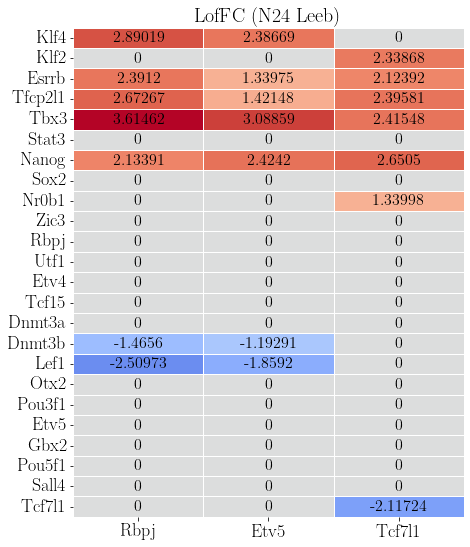

In [15]:
correlations_list = funcs_general.InteractionList(df_KO_N24_Leeb_cl, perc = 0.3)

fun_plotting.plot_log2FC(df_KO_N24_Leeb_cl, "LofFC (N24 Leeb)")

# Bulk Data

In [19]:
path_data+"input_data/geni_IMP.xlsx"

'/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/DATA/input_data/geni_IMP.xlsx'

In [24]:
imp_genes = np.loadtxt(path_data+"general_info/imp_genes.csv", dtype="str")

file_name = path_data+"input_data/geni_IMP.xlsx"
df_bulk_all = pd.read_excel(file_name).set_index(imp_genes).reindex(genes_order)

df_bulk = df_bulk_all.iloc[:,2: ]
df_bulk.head(4)

# df2iL = df.iloc[:,2:18]
# df2i = df.iloc[:,18:]
# ntime=np.array([0, 0, 24, 24, 36, 36, 48, 48, 60, 60, 72, 72, 84, 84, 96, 96])



,GM_2iL_2,GM_2iL_1,GM_24h_2iL_2,GM_24h_2iL_1,GM_36h_2iL_2,GM_36h_2iL_1,GM_48h_2iL_2,GM_48h_2iL_1,GM_60h_2iL_2,GM_60h_2iL_1,...,GM_36h_2i_1,GM_36h_2i_2,GM_48h_2i_1,GM_48h_2i_2,GM_60h_2i_1,GM_60h_2i_2,GM_72h_2i_1,GM_72h_2i_2,GM_84h_2i_1,GM_84h_2i_2
Klf4,721.246075,790.448527,362.034812,507.580169,338.426474,275.595044,109.118435,141.201368,31.593545,46.465603,...,15.825195,7.814844,19.079327,14.208553,38.803582,25.553683,17.314668,14.76264,31.121266,16.477378
Klf2,300.890974,288.413501,124.602767,102.125740,87.270395,86.229124,51.552016,27.900029,31.593545,34.418965,...,25.056559,32.040862,42.928486,27.909658,39.896640,34.467758,16.527638,14.76264,13.103691,5.703708
Esrrb,179.939742,201.400614,103.999160,83.834562,47.694286,52.413781,24.916808,11.228061,6.651273,6.453556,...,3.956299,3.125938,4.769832,1.522345,2.186117,4.159902,3.148121,1.84533,1.637961,3.168726
Tfcp2l1,797.584148,796.803401,135.395133,111.271328,69.511885,70.166836,22.339207,18.713434,6.097000,6.453556,...,7.912597,5.470391,6.359776,6.089380,7.104881,7.725532,4.722182,9.22665,12.284710,8.238689


# Correlation Matrices

In [26]:
# bulk
cm_bulk = np.corrcoef(df_bulk)
np.fill_diagonal(cm_bulk, float("Nan")) 

# raw
cm_raw = np.corrcoef(df_raw)
np.fill_diagonal(cm_raw, float("Nan")) 

# logNorm
cm_lN = np.corrcoef(df_lN)
np.fill_diagonal(cm_lN, float("Nan")) 

# psiNorm
cm_pN = np.corrcoef(df_pN)
np.fill_diagonal(cm_pN, float("Nan")) 

# mini-bulk on raw
cm_raw_mb = np.corrcoef(df_raw_mb)
np.fill_diagonal(cm_raw_mb, float("Nan")) 

# mini-bulk on logNorm
cm_lN_mb = np.corrcoef(df_lN_mb)
np.fill_diagonal(cm_lN_mb, float("Nan")) 

# mini-bulk on psiNorm
cm_pN_mb = np.corrcoef(df_pN_mb)
np.fill_diagonal(cm_pN_mb, float("Nan")) 

# mini-bulk WITH PST on LogNorm
cm_lN_mb_pst = np.corrcoef(df_lN_mb_pst)
np.fill_diagonal(cm_lN_mb_pst, float("Nan")) 

# mini-bulk WITH PST on PsiNorm
cm_pN_mb_pst = np.corrcoef(df_pN_mb_pst)
np.fill_diagonal(cm_pN_mb_pst, float("Nan")) 


NameError: name 'df_raw' is not defined